In [1]:
from io import open
import os
import glob

In [2]:
print(glob.glob('data/data/names/*.txt'))

['data/data/names\\Arabic.txt', 'data/data/names\\Chinese.txt', 'data/data/names\\Czech.txt', 'data/data/names\\Dutch.txt', 'data/data/names\\English.txt', 'data/data/names\\French.txt', 'data/data/names\\German.txt', 'data/data/names\\Greek.txt', 'data/data/names\\Irish.txt', 'data/data/names\\Italian.txt', 'data/data/names\\Japanese.txt', 'data/data/names\\Korean.txt', 'data/data/names\\Polish.txt', 'data/data/names\\Portuguese.txt', 'data/data/names\\Russian.txt', 'data/data/names\\Scottish.txt', 'data/data/names\\Spanish.txt', 'data/data/names\\Vietnamese.txt']


In [3]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

In [4]:
n_letters

57

In [5]:
language_names = {}
all_languages = []

In [6]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [7]:
unicodeToAscii('Ślusàrski')

'Slusarski'

In [8]:
def findFiles(path):
    return glob.glob(path)

In [9]:
total_names = 0

for filename in findFiles('data/data/names/*.txt'):
    language = os.path.splitext(os.path.basename(filename))[0]
    all_languages.append(language)
    with open(filename, encoding='utf-8') as f:
        read_names = f.read().strip().split('\n')
    names = [unicodeToAscii(name) for name in read_names]
    language_names[language] = names
    total_names += len(names)

In [10]:
all_languages

['Arabic',
 'Chinese',
 'Czech',
 'Dutch',
 'English',
 'French',
 'German',
 'Greek',
 'Irish',
 'Italian',
 'Japanese',
 'Korean',
 'Polish',
 'Portuguese',
 'Russian',
 'Scottish',
 'Spanish',
 'Vietnamese']

In [11]:
n_languages = len(all_languages)
n_languages

18

In [12]:
total_names

20074

In [13]:
language_names['Italian'][:5]

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']

In [14]:
import torch

In [15]:
def letterToTensor(letter):
    '''
    One-hot encoding of a letter
    '''
    tensor = torch.zeros(1, n_letters)
    tensor[0][all_letters.find(letter)] = 1
    return tensor

In [16]:
letterToTensor('J')

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])

In [17]:
def nameToTensor(name):
    '''
    One-hot encoding of a name
    '''
    tensor = torch.zeros(len(name), 1, n_letters)
    for li, letter in enumerate(name):
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

In [18]:
nameToTensor('Jules').size()

torch.Size([5, 1, 57])

In [19]:
import torch.nn as nn

class RNN(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):

        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)

        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [20]:
n_hidden = 256
rnn = RNN(n_letters, n_hidden, n_languages)

In [21]:
# Example of training with one character
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input, hidden)
print(f'Output size: {output.size()}')
print(f'Next hidden size: {next_hidden.size()}')

Output size: torch.Size([1, 18])
Next hidden size: torch.Size([1, 256])


In [22]:
# Example of training with a name
input = nameToTensor('Albert')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input[0], hidden)
print(f'Output size: {output.size()}')
print(f'Next hidden size: {next_hidden.size()}')

Output size: torch.Size([1, 18])
Next hidden size: torch.Size([1, 256])


In [23]:
def languageFromOutput(output):
    _, top_i = output.topk(1)
    language_i = top_i[0].item()
    return all_languages[language_i], language_i

In [24]:
languageFromOutput(output)

('English', 4)

In [25]:
import random

def randomTrainingExample():

    random_language_index = random.randint(0, n_languages - 1)
    language = all_languages[random_language_index]

    random_language_names = language_names[language]
    name = random_language_names[random.randint(0, len(random_language_names) - 1)]

    language_tensor = torch.tensor([all_languages.index(language)], dtype=torch.long)
    name_tensor = nameToTensor(name)

    return language, name, language_tensor, name_tensor

In [26]:
for i in range(10):
    language, name, language_tensor, name_tensor = randomTrainingExample()
    print(f'language: {language}; name: {name}')

language: Polish; name: Zientek
language: Spanish; name: Vicario
language: English; name: Ewin
language: Portuguese; name: Henriques
language: Spanish; name: Loyola
language: Arabic; name: Moghadam
language: Spanish; name: Crespo
language: Vietnamese; name: Pham
language: Portuguese; name: D'cruz
language: Scottish; name: Whyte


In [27]:
criterion = nn.NLLLoss()
LEARNING_RATE = 0.005

In [28]:
def train(language_tensor, name_tensor):

    hidden = rnn.initHidden()
    rnn.zero_grad()

    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)
    
    loss = criterion(output, language_tensor)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-LEARNING_RATE)
    
    return output, loss.item()

In [29]:
n_iters = 200000
current_loss = 0
all_losses = []

In [30]:
for epoch in range(1, n_iters + 1):

    language, name, language_tensor, name_tensor = randomTrainingExample()

    output, loss = train(language_tensor, name_tensor)
    current_loss += loss

    if epoch % 5000 == 0:
        guess, guess_i = languageFromOutput(output)
        correct = '✓' if guess == language else '✗ (%s)' % language
        print(f'{epoch:5} {epoch / n_iters * 100}% | {loss:.4f} | {name} / {guess} | {correct}')
        
    if epoch % 1000 == 0:
        all_losses.append(current_loss / 1000)
        current_loss = 0

 5000 2.5% | 2.8711 | Fabel / Arabic | ✗ (German)
10000 5.0% | 0.8798 | Mai / Chinese | ✓
15000 7.5% | 2.1620 | Trent / German | ✗ (English)
20000 10.0% | 2.3631 | Whyte / Korean | ✗ (Scottish)
25000 12.5% | 0.3071 | Sokolofsky / Polish | ✓
30000 15.0% | 0.2975 | Nakamoto / Japanese | ✓
35000 17.5% | 3.1148 | Baz / Chinese | ✗ (Arabic)
40000 20.0% | 4.1902 | Roganovich / Portuguese | ✗ (Russian)
45000 22.5% | 2.3007 | Bordelon / Scottish | ✗ (French)
50000 25.0% | 0.5771 | Dounias / Greek | ✓
55000 27.500000000000004% | 0.7155 | Sheng / Chinese | ✓
60000 30.0% | 1.3030 | Melo / Spanish | ✗ (Portuguese)
65000 32.5% | 2.2370 | Amersvoort / Greek | ✗ (Dutch)
70000 35.0% | 1.3857 | Klerx / Scottish | ✗ (Dutch)
75000 37.5% | 2.0541 | Overing / Irish | ✗ (English)
80000 40.0% | 1.2587 | Bautista / Italian | ✗ (Spanish)
85000 42.5% | 0.2123 | Jalamov / Russian | ✓
90000 45.0% | 0.2341 | Martelli / Italian | ✓
95000 47.5% | 1.3614 | Faraldo / Portuguese | ✗ (Italian)
100000 50.0% | 0.3341 | Ha

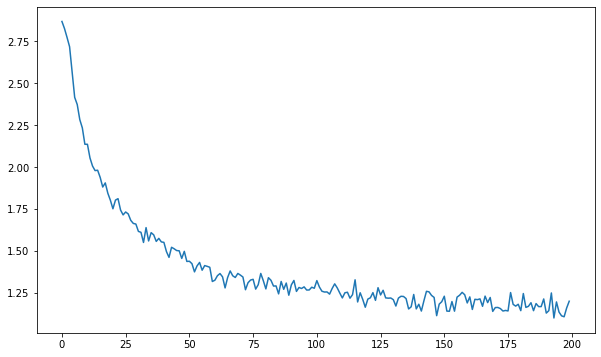

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(all_losses)
plt.show();

In [33]:
n_predictions = 3

In [34]:
input_name = 'Batsakis' # Greek

In [35]:
with torch.no_grad():

    name_tensor = nameToTensor(input_name)

    hidden = rnn.initHidden()

    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)
    
    topv, topi = output.topk(n_predictions, 1, True)

    for i in range(n_predictions):
        value = topv[0][i].item()
        language_index = topi[0][i].item()

        print(f'{value:.4f} => {all_languages[language_index]}')

-0.0663 => Greek
-3.0392 => Russian
-5.5548 => Scottish


In [36]:
for input_name in [
    'Amaya', # Arabic / Japanese
    'Bukoski' # Polish
]:

    print(f'\n\nPredictions for {input_name}')

    with torch.no_grad():
            
            name_tensor = nameToTensor(input_name)
    
            hidden = rnn.initHidden()
    
            for i in range(name_tensor.size()[0]):
                output, hidden = rnn(name_tensor[i], hidden)
            
            topv, topi = output.topk(n_predictions, 1, True)
    
            for i in range(n_predictions):
                value = topv[0][i].item()
                language_index = topi[0][i].item()
    
                print(f'\t{value:.4f} => {all_languages[language_index]}')



Predictions for Amaya
	-0.1924 => Japanese
	-2.1442 => Arabic
	-4.3841 => Spanish


Predictions for Bukoski
	-0.0950 => Polish
	-2.7781 => Japanese
	-4.3210 => Russian
